In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-08-13 13:41:07.548710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755092467.908937      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755092468.006645      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_36/652326744.py:51: RuntimeWarning: invalid value encountered in log1p
  data = np.log1p(data)
/tmp/ipykernel_36/652326744.py:53: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)
I0000 00:00:1755092675.949101      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T

Epoch 1/10


I0000 00:00:1755092687.029344     112 service.cc:148] XLA service 0x7a423800fcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755092687.031142     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755092687.031163     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755092687.527338     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/110 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.0816 - loss: 1.8120  

I0000 00:00:1755092693.931845     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.2102 - loss: 1.7643 - val_accuracy: 0.2867 - val_loss: 1.6472
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3453 - loss: 1.6239 - val_accuracy: 0.6613 - val_loss: 1.4828
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6234 - loss: 1.4628 - val_accuracy: 0.7933 - val_loss: 1.2614
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7594 - loss: 1.2324 - val_accuracy: 0.8213 - val_loss: 0.9984
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8187 - loss: 0.9703 - val_accuracy: 0.8547 - val_loss: 0.7490
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8843 - loss: 0.7177 - val_accuracy: 0.9240 - val_loss: 0.5401
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9095 - loss: 0.5265 - val_accuracy: 0.9240 - val_loss: 0.4078
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9332 - loss: 0.4011 - val_accuracy: 0.9

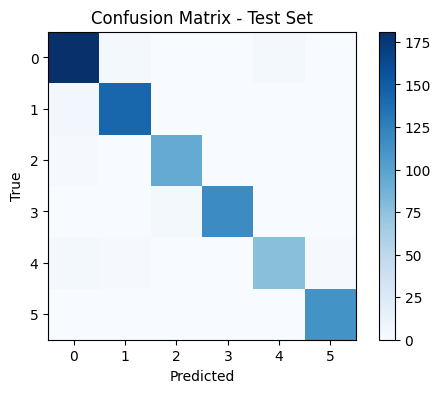

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import pyarrow.parquet as pq
import io
import scipy.signal
from PIL import Image

# Define dataset directories
data_csv = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
parquet_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms"

# Load metadata
df = pd.read_csv(data_csv)

# Filter rows that have corresponding parquet files
existing_files = set(os.listdir(parquet_dir))
df = df[df["spectrogram_id"].apply(lambda x: f"{x}.parquet" in existing_files)]

# Limit to first 5000 samples
df = df.head(5000)

if df.empty:
    raise ValueError("No matching parquet files found. Check your directory and filenames.")

# Encode labels
y = df["expert_consensus"].dropna()
df = df.loc[y.index]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Metadata features
X_meta = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].values
scaler = StandardScaler()
X_meta = scaler.fit_transform(X_meta)

# Helper to convert spectrogram parquet to image array
def load_spectrogram_as_image(spectrogram_id, size=(224, 224)):
    file_path = os.path.join(parquet_dir, f"{spectrogram_id}.parquet")
    table = pq.read_table(file_path)
    data = table.to_pandas().values.T  # Transpose to get (freq, time)
    data = np.log1p(data)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)
    return np.array(img) / 255.0

# Load spectrogram images
X_images = np.stack([load_spectrogram_as_image(sid) for sid in df["spectrogram_id"]])

# Split dataset
X_img_train, X_img_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    X_images, X_meta, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)
X_img_val, X_img_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    X_img_temp, X_meta_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define RetNet-inspired image model 
from tensorflow.keras.applications import ResNet50

image_input = keras.Input(shape=(224, 224, 3), name="image_input")
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
image_features = layers.Dropout(0.3)(x)

# Metadata model
meta_input = keras.Input(shape=(X_meta.shape[1],), name="meta_input")
y_meta = layers.Dense(32, activation='relu')(meta_input)
meta_features = layers.Dense(16, activation='relu')(y_meta)

# Merge models
merged = layers.concatenate([image_features, meta_features])
z = layers.Dense(64, activation='relu')(merged)
out = layers.Dense(y_categorical.shape[1], activation='softmax')(z)

model = keras.Model(inputs=[image_input, meta_input], outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    x=[X_img_train, X_meta_train],
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_img_val, X_meta_val], y_val)
)

# Evaluate model
y_pred = model.predict([X_img_test, X_meta_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("Test Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(6, 4))
plt.imshow(confusion_matrix(y_true_classes, y_pred_classes), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Explaining Test Sample Index: 444, True Class: GPD


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

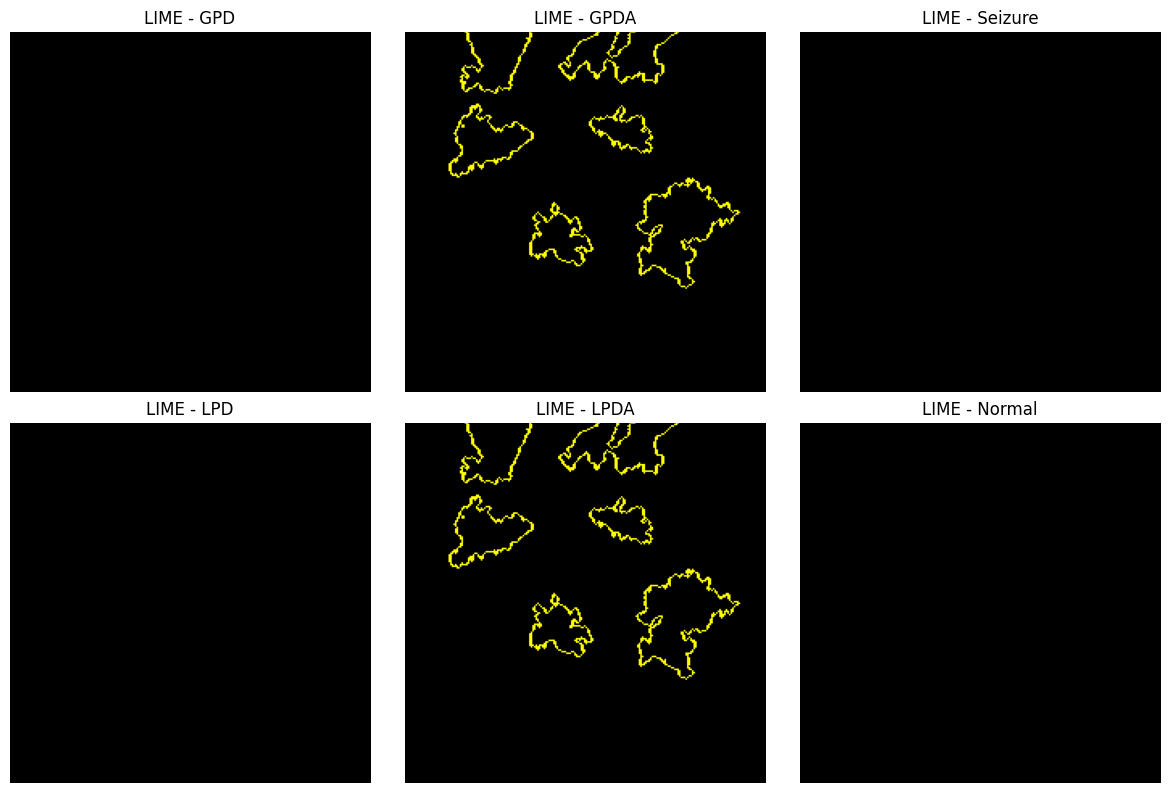

In [87]:
!pip install lime --quiet

from lime import lime_image
from skimage.segmentation import mark_boundaries
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# --------------------------
# 1. Define class name mapping
# --------------------------
class_names = [
    "Seizure",
    "LPDA",
    "LPD",
    "Normal",
    "GPD",
    "GPDA"
]

# --------------------------
# 2. Pick a random test image
# --------------------------
idx = np.random.randint(0, len(X_img_test)-1)
test_img = X_img_test[idx]
true_label = np.argmax(y_test[idx])
print(f"Explaining Test Sample Index: {idx}, True Class: {class_names[true_label]}")

# --------------------------
# 3. LIME prediction wrapper
# --------------------------
def predict_fn(images):
    images = tf.image.resize(images, (224, 224))  # Ensure size
    metas = np.tile(X_meta_test[idx], (images.shape[0], 1))  # Repeat metadata
    return model.predict([images, metas])

# --------------------------
# 4. Run LIME
# --------------------------
explainer = lime_image.LimeImageExplainer()
num_classes = model.output_shape[-1]  # Get total classes

explanation = explainer.explain_instance(
    image=test_img,
    classifier_fn=predict_fn,
    top_labels=num_classes,  # Explain all classes
    hide_color=0,
    num_samples=1000
)

# --------------------------
# 5. Plot results in a 2×3 grid
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, label in enumerate(explanation.top_labels):
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    axes[i].imshow(mark_boundaries(temp, mask))
    axes[i].set_title(f"LIME - {class_names[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Explaining test sample index: 449, True class: Seizure


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

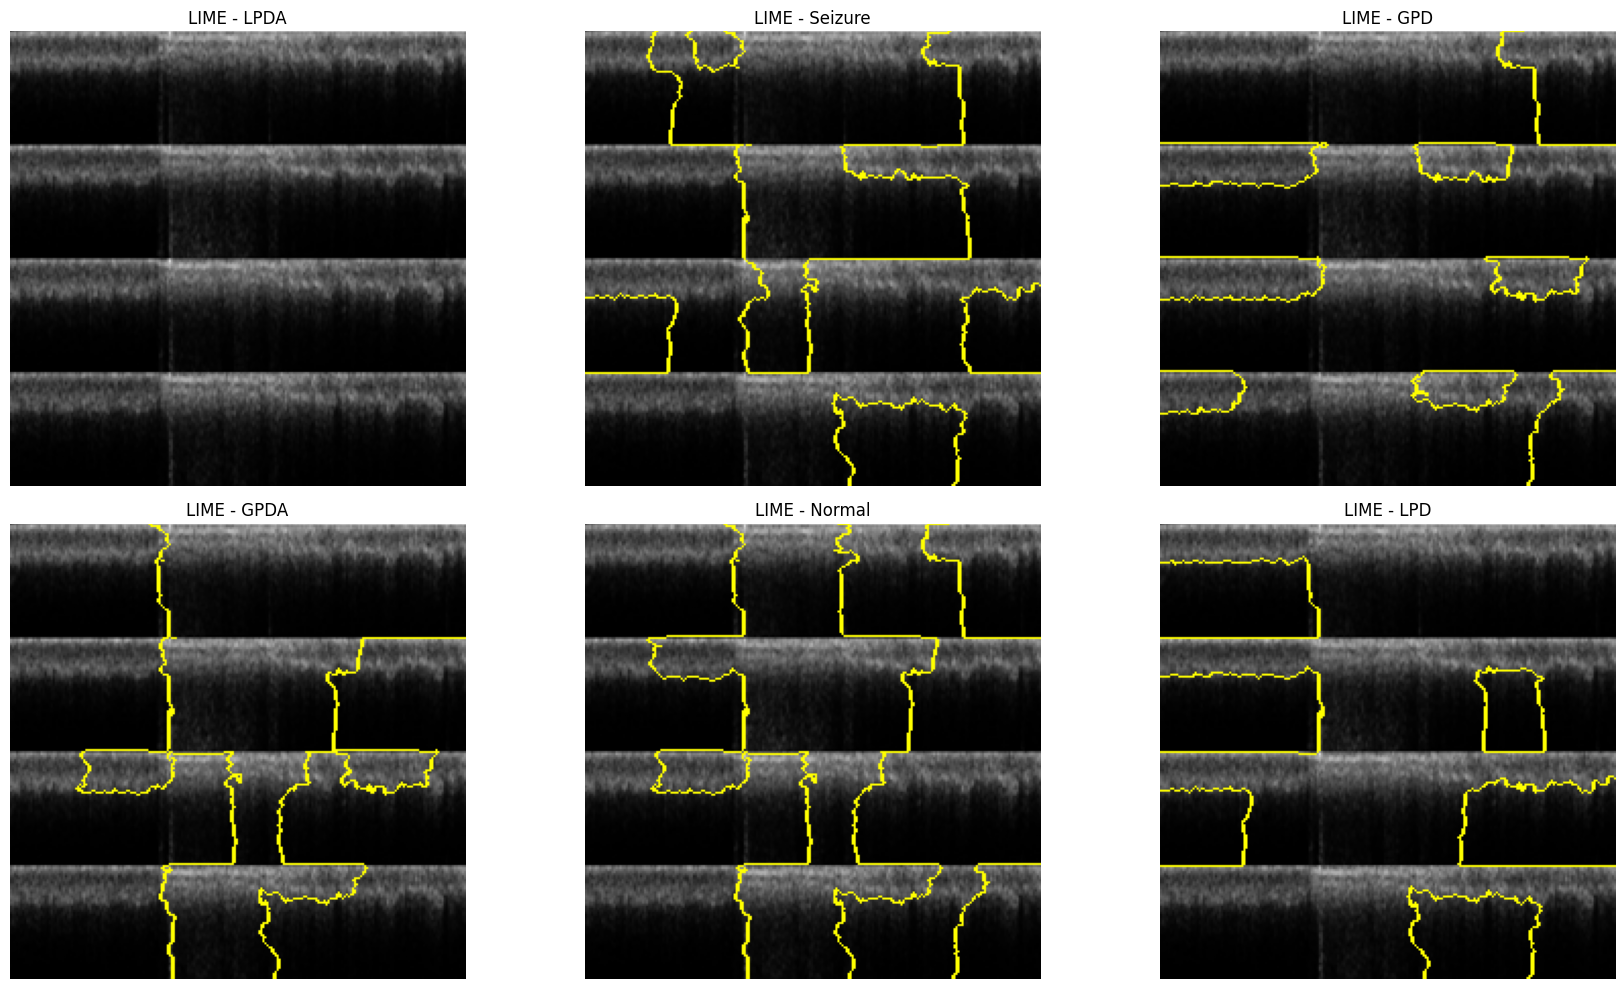

In [88]:
!pip install lime --quiet

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# --------------------------
# Class names for 6 diseases (update order if needed)
# --------------------------
class_names = [
    "Seizure",
    "LPDA",
    "LPD",
    "Normal",
    "GPD",
    "GPDA"
]

# Choose a random test image index
idx = 449
test_img = X_img_test[idx]
true_label = np.argmax(y_test[idx])

print(f"Explaining test sample index: {idx}, True class: {class_names[true_label]}")

# Define classifier function for LIME (resizes + adds metadata)
def predict_fn(images):
    images_resized = tf.image.resize(images, (224, 224)).numpy()
    metas = np.tile(X_meta_test[idx], (images_resized.shape[0], 1))
    return model.predict([images_resized, metas])

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Run LIME explanation on the test image
explanation = explainer.explain_instance(
    image=test_img,
    classifier_fn=predict_fn,
    top_labels=6,          # Number of classes
    hide_color=0,
    num_samples=1000
)

# Plot explanations for all classes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2x3 grid for 6 classes
axes = axes.flatten()

for i, class_id in enumerate(explanation.top_labels):
    temp, mask = explanation.get_image_and_mask(
        label=class_id,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    
    axes[i].imshow(mark_boundaries(temp, mask))
    axes[i].set_title(f"LIME - {class_names[class_id]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Explaining Test Sample Index: 42, True Class: Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

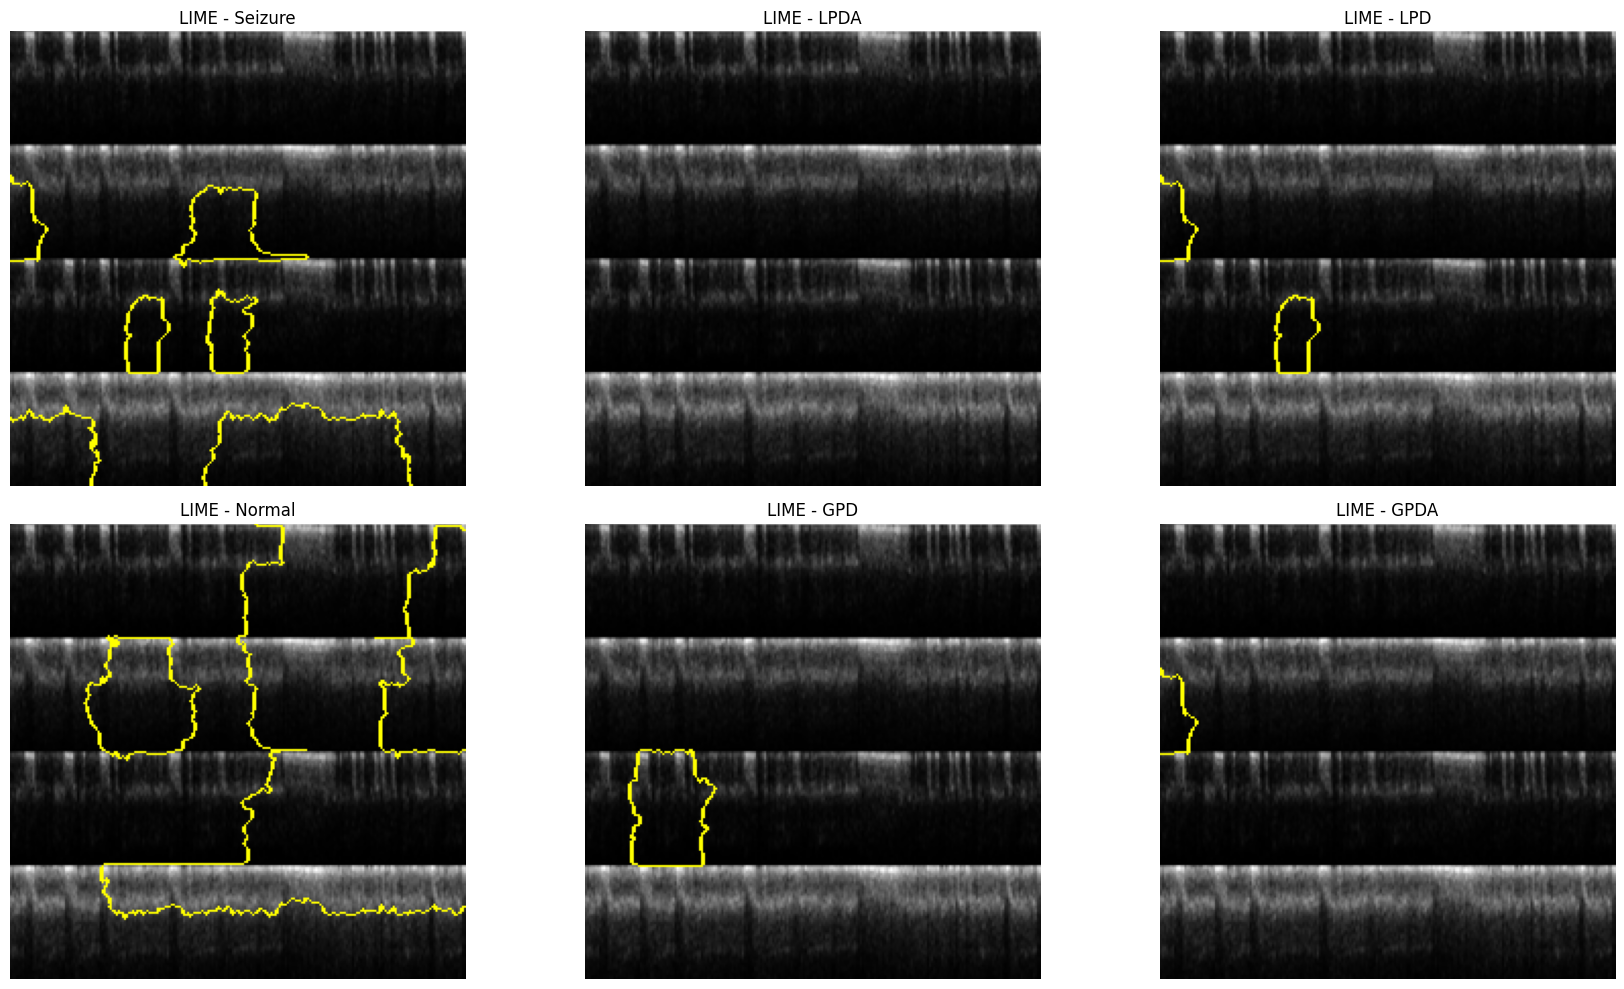

In [89]:
!pip install lime --quiet

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --------------------------
# 1. Class names in correct order
# --------------------------
class_names = [
    "Seizure",
    "LPDA",
    "LPD",
    "Normal",
    "GPD",
    "GPDA"
]

num_classes = len(class_names)

# --------------------------
# 2. Set seeds for reproducibility
# --------------------------
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

# --------------------------
# 3. Pick a fixed test image index
# --------------------------
idx = 42  # <-- change if you want a different fixed sample
test_img = X_img_test[idx]
true_label = np.argmax(y_test[idx])
print(f"Explaining Test Sample Index: {idx}, True Class: {class_names[true_label]}")

# --------------------------
# 4. Define LIME prediction wrapper
# --------------------------
def predict_fn(images):
    images_resized = tf.image.resize(images, (224, 224)).numpy()
    metas = np.tile(X_meta_test[idx], (images_resized.shape[0], 1))
    return model.predict([images_resized, metas])

# --------------------------
# 5. Create and run LIME explainer
# --------------------------
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=test_img,
    classifier_fn=predict_fn,
    top_labels=num_classes,    # Explain all classes
    hide_color=0,
    num_samples=1000
)

# --------------------------
# 6. Plot all classes in fixed order (0 to 5)
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for class_id in range(num_classes):  # Fixed order
    temp, mask = explanation.get_image_and_mask(
        label=class_id,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    axes[class_id].imshow(mark_boundaries(temp, mask))
    axes[class_id].set_title(f"LIME - {class_names[class_id]}")
    axes[class_id].axis('off')

plt.tight_layout()
plt.show()


Explaining test sample index: 718, True class: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

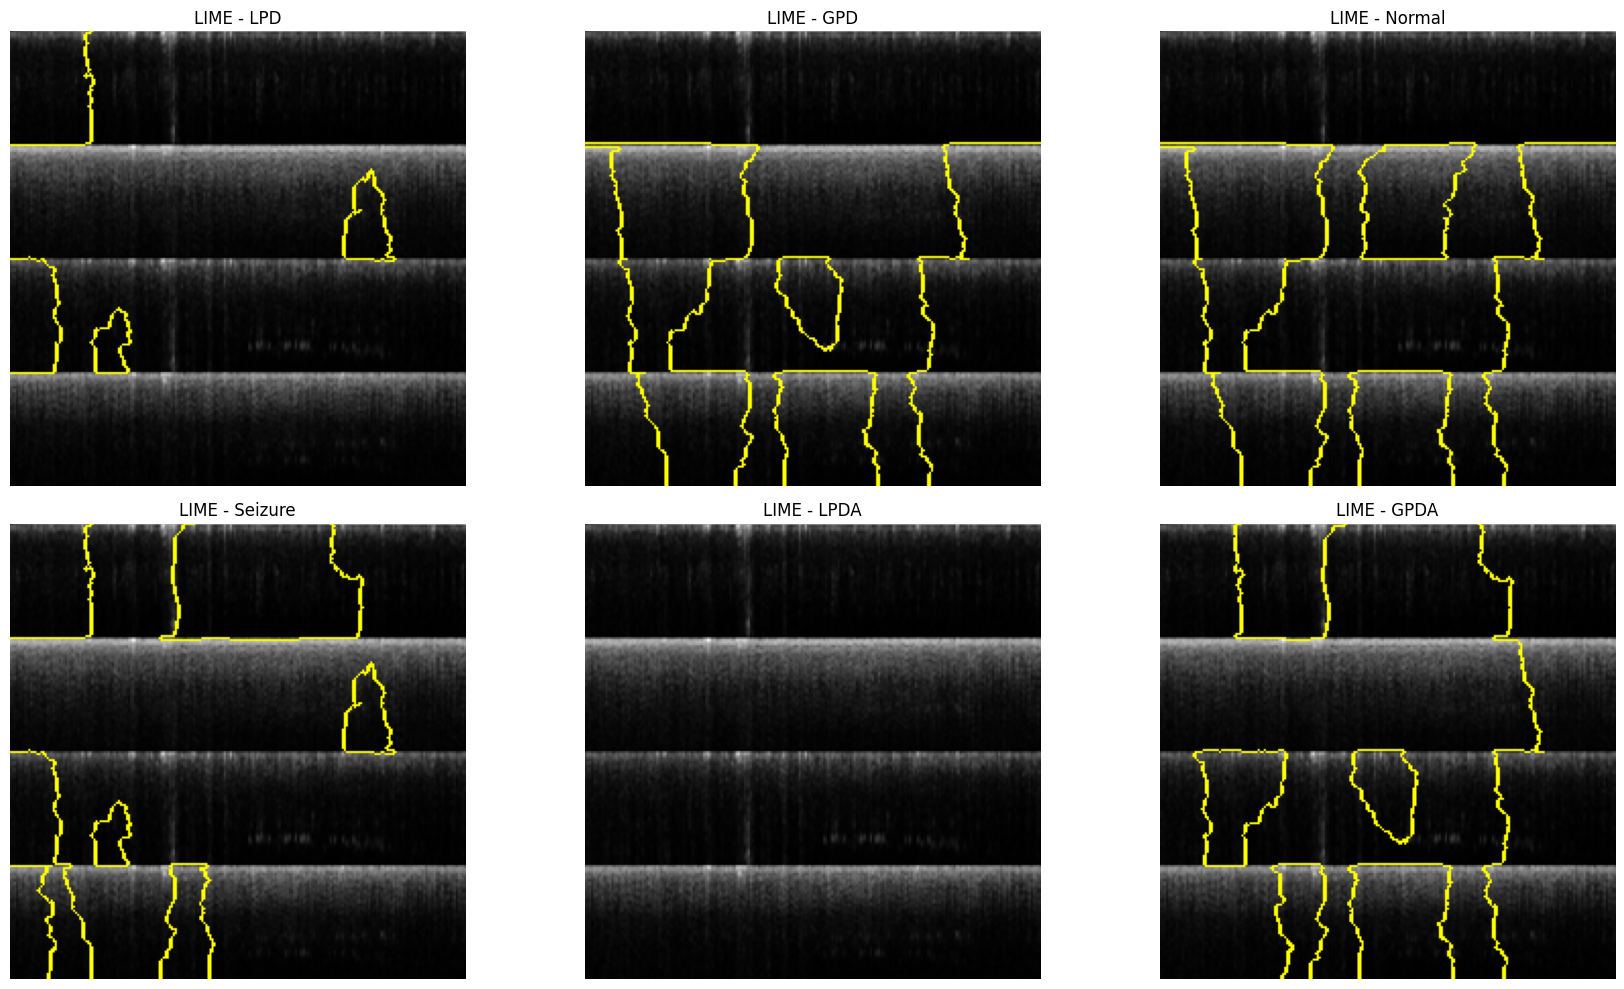

In [90]:
!pip install lime --quiet

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb

# Choose a random test image index
idx = np.random.randint(0, len(X_img_test))
test_img = X_img_test[idx]
true_label = np.argmax(y_test[idx])

print(f"Explaining test sample index: {idx}, True class: {true_label}")

# Define classifier function for LIME (resizes + adds metadata)
def predict_fn(images):
    images_resized = tf.image.resize(images, (224, 224)).numpy()
    metas = np.tile(X_meta_test[idx], (images_resized.shape[0], 1))
    return model.predict([images_resized, metas])

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Run LIME explanation on the test image
explanation = explainer.explain_instance(
    image=test_img,
    classifier_fn=predict_fn,
    top_labels=6,          # Set to number of total classes
    hide_color=0,
    num_samples=1000
)

# Plot explanations for **all classes**
num_classes = 6  # Replace with your actual number of classes

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjust subplot size for 6 classes
axes = axes.flatten()

for i, class_id in enumerate(explanation.top_labels):
    temp, mask = explanation.get_image_and_mask(
        label=class_id,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    
    axes[i].imshow(mark_boundaries(temp, mask))
    axes[i].set_title(f"LIME - {class_names[class_id]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()